In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd().replace("notebooks/distilled_models", "")))

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from config import Config
from data.dataset import NetworkDataset, load_datasets
from utils.plot import plot_precision_recall_f1, plot_fpr_tpr_roc_auc, plot_loss
from model_config import CNN_models, MLP_Models, LSTM_Models, GRU_Models
from compact.knowledge_distillation import KnowledgeDistillation

In [2]:
conf = Config()
load_models = CNN_models()
teacher_conf = load_models.cnn_4
student_conf = load_models.light_cnn_1
teacher_model = load_models.get_model(teacher_conf)
teacher_model.load()
student_model = load_models.get_model(student_conf)

kd = KnowledgeDistillation(
    teacher=teacher_model,
    student=student_model,
    device=conf.device,
    model_type=load_models.type,
    distillation=student_conf["distill_type"]
)

Checkpoint loaded from /global/D1/homes/jorgetf/Network-Packet-ML-Model/checkpoint/large_model/cnn_4.pth!


In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = load_datasets(conf.datasets, load_models.type)

print(X_train.shape)

# create train, val and test dataloaders
train_dataset = NetworkDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, conf.batch_size, shuffle=True, num_workers=8)

val_dataset = NetworkDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, conf.batch_size, shuffle=True, num_workers=8)

test_dataset = NetworkDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, conf.batch_size, shuffle=True, num_workers=8)

torch.Size([356334, 1, 513])


In [4]:
train_metrics, train_loss, val_loss = kd.train_kd(train_loader, val_loader, conf.epochs)

OutOfMemoryError: CUDA out of memory. Tried to allocate 10816.00 GiB. GPU 0 has a total capacity of 79.15 GiB of which 71.99 GiB is free. Process 1718172 has 6.52 GiB memory in use. Including non-PyTorch memory, this process has 644.00 MiB memory in use. Of the allocated memory 105.61 MiB is allocated by PyTorch, and 36.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
test_loss, metrics = student_model.evaluate(test_loader)
print(f"Macro-F1 score: {metrics['f1_macro']:.2f}, Micro-F1 score: {metrics['f1_micro']:.2f}, Macro ROC AUC score: {metrics['roc_auc_macro']:.2f}")

Macro-F1 score: 0.64, Micro-F1 score: 0.87, Macro ROC AUC score: 0.98


In [ ]:
student_model.save()

Checkpoint saved at /global/D1/homes/jorgetf/Network-Packet-ML-Model/checkpoint/compressed_model/result_light_cnn_1.pth


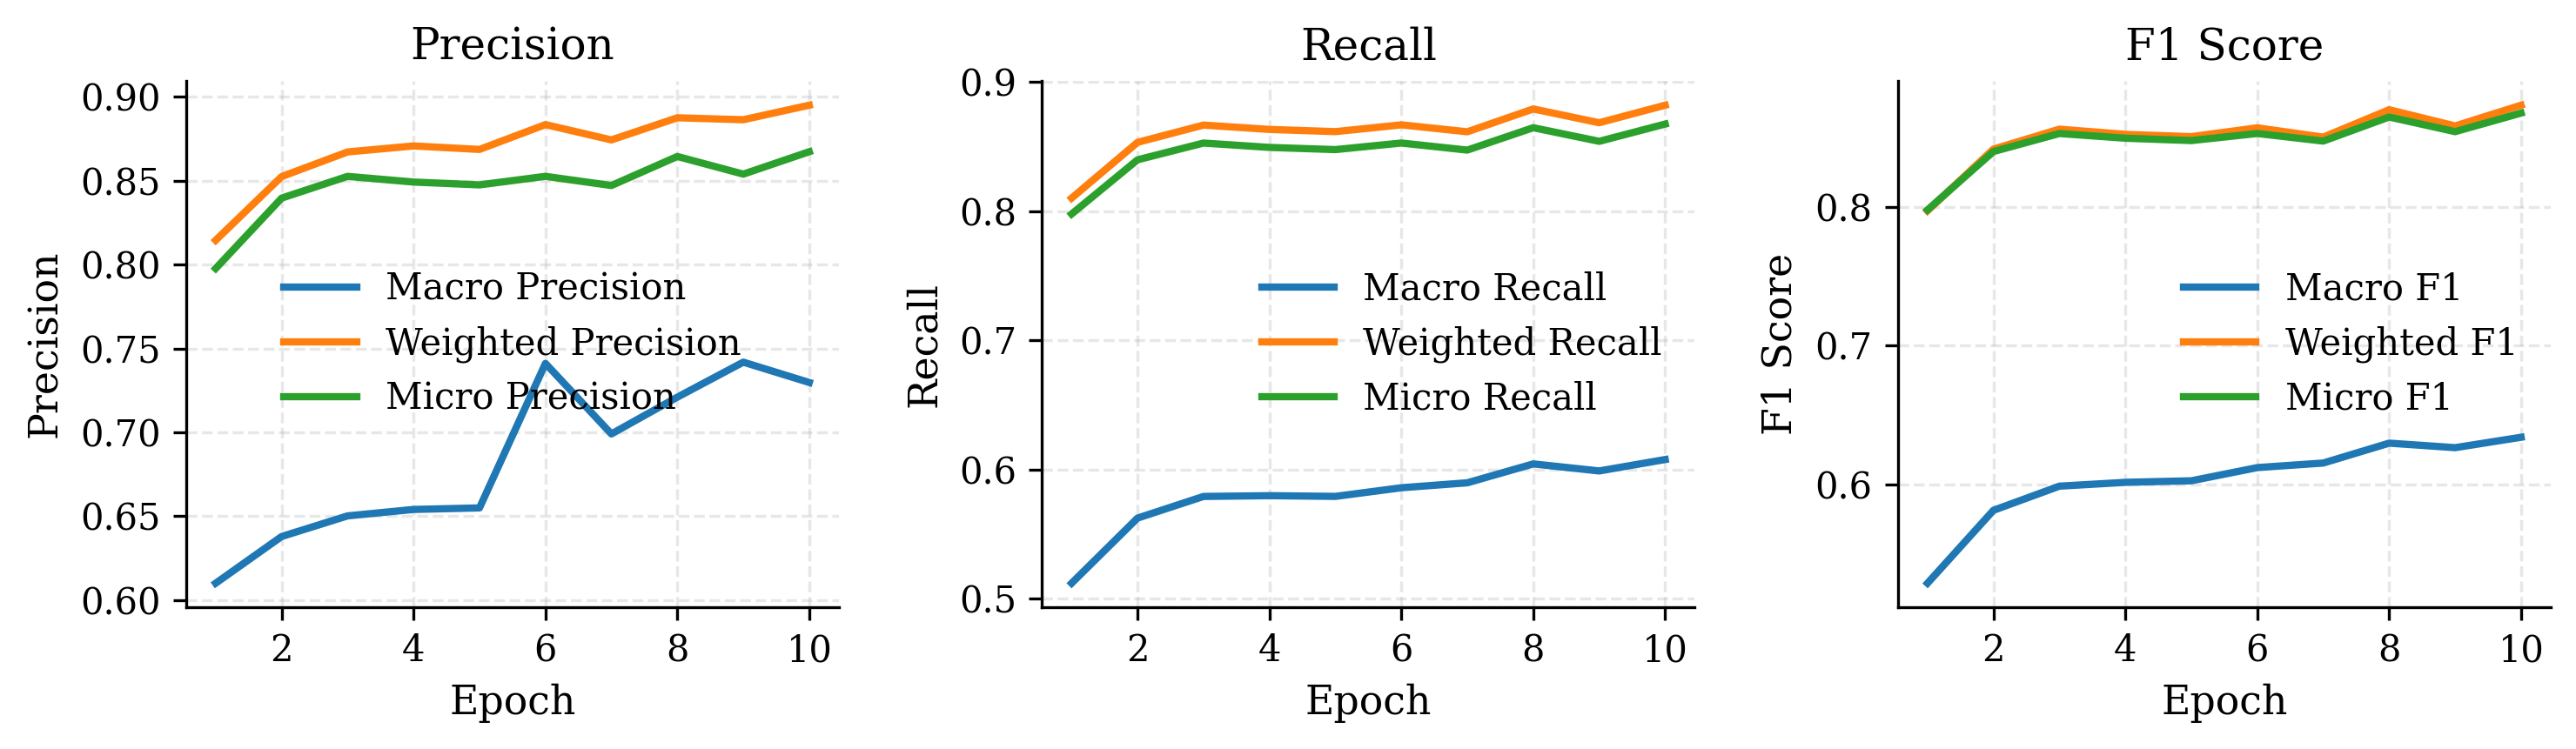

In [ ]:
train_plot_path = os.path.join(os.getcwd().replace("notebooks/distilled_models", ""), "plots", "distillation", student_conf["distill_type"], "train_" + student_conf["name"] + ".png")
plot_precision_recall_f1(train_metrics, train_plot_path)

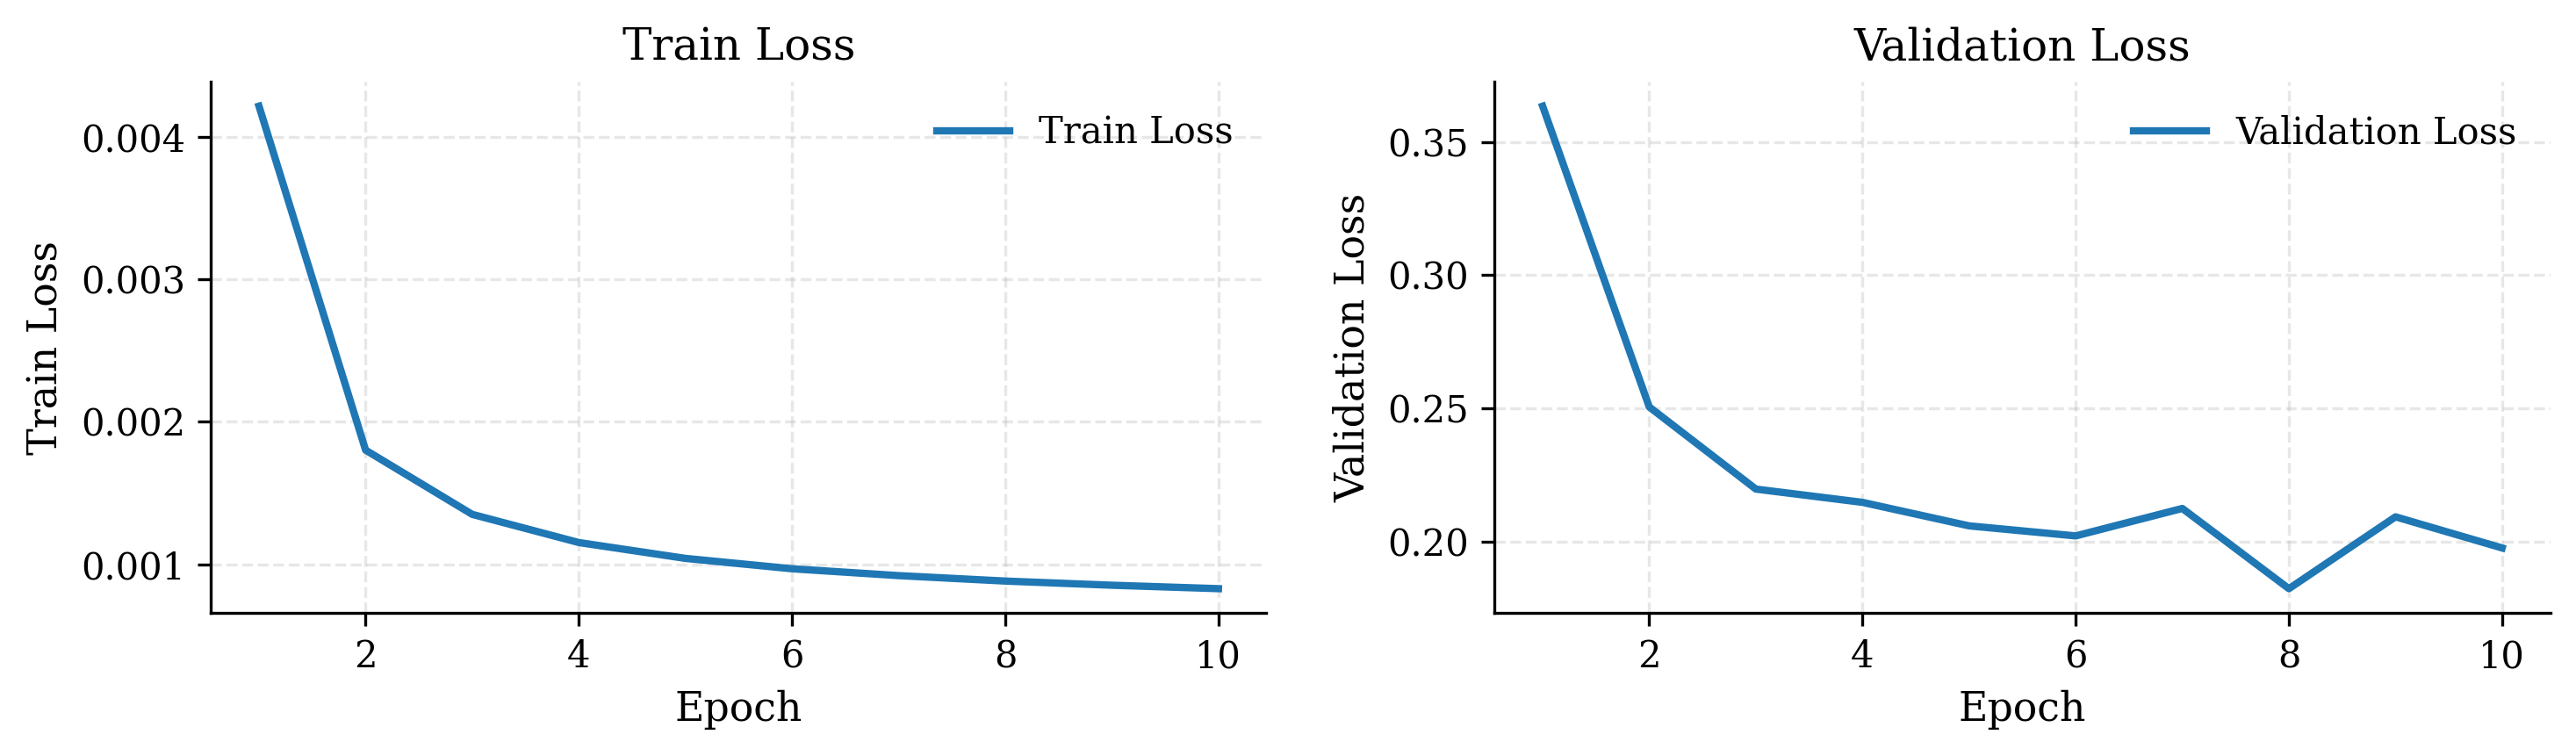

In [ ]:
loss_plot_path = os.path.join(os.getcwd().replace("notebooks/distilled_models", ""), "plots", "distillation", student_conf["distill_type"], "loss_" + student_conf["name"] + ".png")
plot_loss(train_loss, val_loss, loss_plot_path)

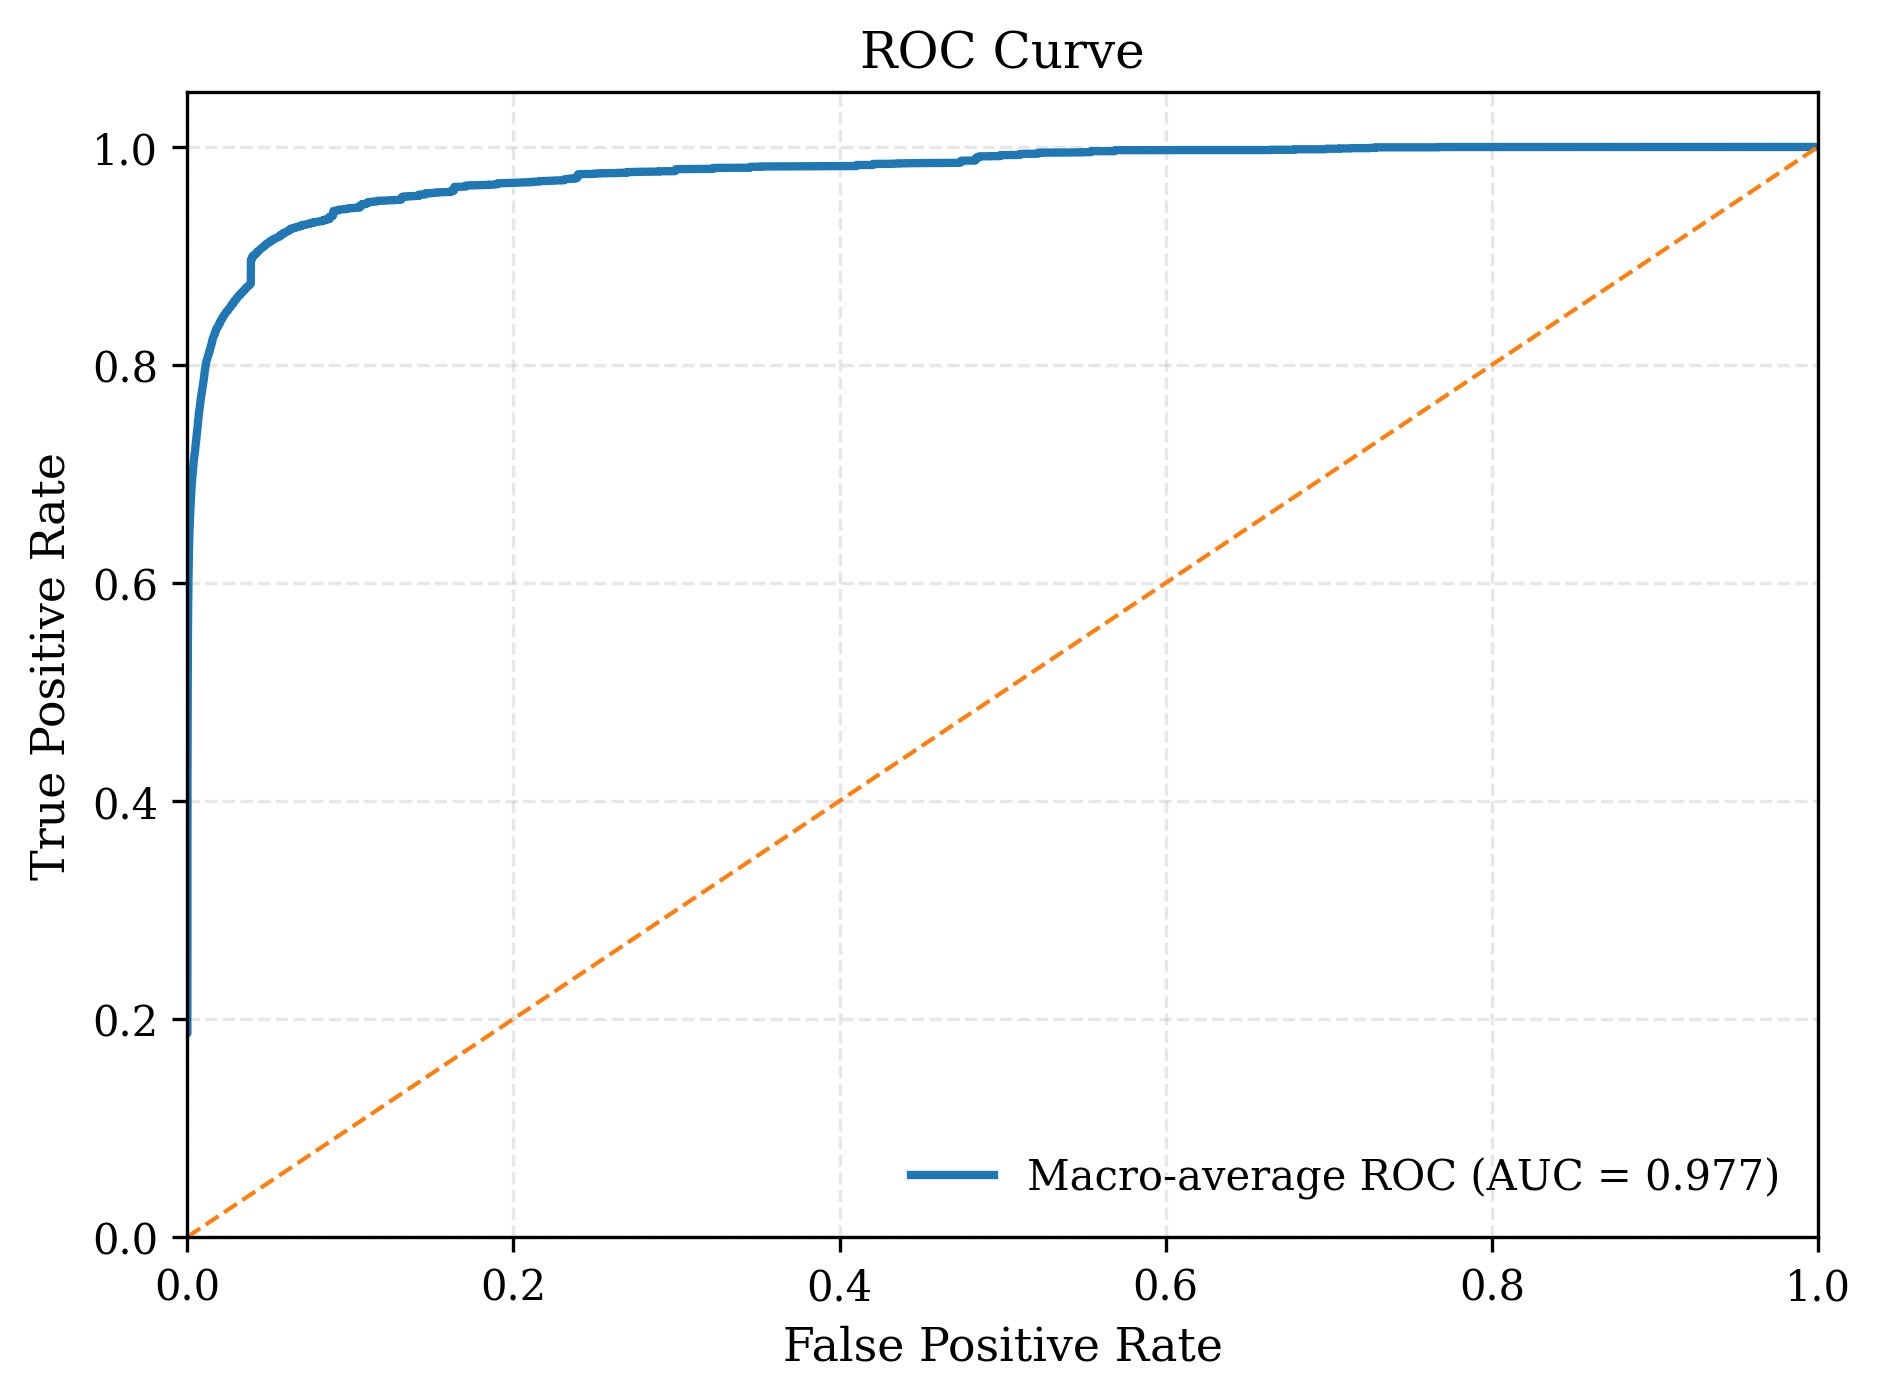

In [ ]:
roc_auc_path = os.path.join(os.getcwd().replace("notebooks/distilled_models", ""), "plots", "distillation", student_conf["distill_type"], "roc_auc_" + student_conf["name"] + ".png")
plot_fpr_tpr_roc_auc(metrics, roc_auc_path)